In [1]:
import fastai
from fastai.vision import *
import scipy.io
from torchvision import models
from visualization.modules import LayeredModule, get_nested_layers
from visualization.data import *
from visualization.image_proc import *
from visualization.interpret import NetLens

# IMDB Dataset 
### 1) Parse MetaData from Matlab file
### 2) Explore Data and choose a random Sample
### 3) Train a Regression model on "Age"

In [2]:
import os
import numpy as np
import scipy.io as sio
import datetime 
import matplotlib.pyplot as plt
from dateutil.relativedelta import relativedelta

### 1) Parse Metadata

In [3]:
path_to_meta = "/home/jupyter/imdb-face-data/imdb_crop/"
matlab_file = 'imdb.mat'

In [4]:
imdb_meta = sio.loadmat(os.path.join(path_to_meta, matlab_file))
imdb = imdb_meta['imdb']

### Utility Function

In [5]:
def reformat_date(mat_date):
    """ Extract only the year.
        Necessary for calculating the age of the individual in the image.
    Args:
        mat_date - raw date format.
    Retrurns:
        dt - adjusted date.
    """
    # Take account for difference in convention between matlab and python.
    dt = datetime.date.fromordinal(np.max([mat_date - 366, 1])).year
    return dt

def matlab_to_numpy(path_to_meta, matlab_file, path_to_images):
    """ Opens .mat file and reformats.
        Matlab struct format to dictionary of numpy arrays.
    Args:
        path_to_meta - path to dir with matlab meta file.
        matlab_file - matlab file
        path_to_images - incomplete paths to images.
    Returns:
        imdb_dict - dict of numpy arrays.
    """
    mat_struct = sio.loadmat(os.path.join(path_to_meta, matlab_file))
    data_set = [data[0] for data in mat_struct['imdb'][0, 0]]

    keys = [
        'dob',
        'photo_taken',
        'full_path',
        'gender',
        'name',
        'face_location',
        'face_score',
        'second_face_score',
        'celeb_names',
        'celeb_id'
    ]

    create_path = lambda path: os.path.join(path_to_images, path[0])

    imdb_dict = dict(zip(keys, np.asarray(data_set)))
    imdb_dict['dob'] = [reformat_date(dob) for dob in imdb_dict['dob']]
    imdb_dict['full_path'] = [create_path(path) for path in imdb_dict['full_path']]

    # Add 'age' key to the dictionary
    imdb_dict['age'] = imdb_dict['photo_taken'] - imdb_dict['dob']

    return imdb_dict

In [6]:
imdb_dict = matlab_to_numpy(path_to_meta, matlab_file, path_to_meta)

### DataFrame Constructor

In [7]:
imdb_df = pd.DataFrame.from_dict(imdb_dict, orient='index').T

In [8]:
imdb_df.head()

,dob,photo_taken,full_path,gender,name,face_location,face_score,second_face_score,celeb_names,celeb_id,age
0,1899,1968,/home/jupyter/imdb-face-data/imdb_crop/01/nm00...,1,[Fred Astaire],"[[1072.926, 161.838, 1214.7839999999999, 303.6...",1.45969,1.11897,['Lee' George Quinones],6488,69
1,1899,1970,/home/jupyter/imdb-face-data/imdb_crop/01/nm00...,1,[Fred Astaire],"[[477.184, 100.352, 622.592, 245.76]]",2.5432,1.85201,['Weird Al' Yankovic],6488,71
2,1899,1968,/home/jupyter/imdb-face-data/imdb_crop/01/nm00...,1,[Fred Astaire],"[[114.96964308962852, 114.96964308962852, 451....",3.45558,2.98566,[2 Chainz],6488,69
3,1899,1968,/home/jupyter/imdb-face-data/imdb_crop/01/nm00...,1,[Fred Astaire],"[[622.8855056426588, 424.21750383700805, 844.3...",1.87212,NaN,[50 Cent],6488,69
4,1899,1968,/home/jupyter/imdb-face-data/imdb_crop/01/nm00...,1,[Fred Astaire],"[[1013.8590023603723, 233.8820422075853, 1201....",1.15877,NaN,[A Martinez],6488,69


In [9]:
imdb_df['name'] = imdb_df['name'].apply(lambda x: " ".join(x))

In [10]:
imdb_df.drop(['face_location', 'face_score','second_face_score','celeb_names','celeb_id'], axis=1,inplace=True)

In [11]:
imdb_df.head()

,dob,photo_taken,full_path,gender,name,age
0,1899,1968,/home/jupyter/imdb-face-data/imdb_crop/01/nm00...,1,Fred Astaire,69
1,1899,1970,/home/jupyter/imdb-face-data/imdb_crop/01/nm00...,1,Fred Astaire,71
2,1899,1968,/home/jupyter/imdb-face-data/imdb_crop/01/nm00...,1,Fred Astaire,69
3,1899,1968,/home/jupyter/imdb-face-data/imdb_crop/01/nm00...,1,Fred Astaire,69
4,1899,1968,/home/jupyter/imdb-face-data/imdb_crop/01/nm00...,1,Fred Astaire,69


In [12]:
imdb_df = imdb_df.infer_objects()
imdb_df.dtypes

dob              int64
photo_taken      int64
full_path       object
gender         float64
name            object
age              int64
dtype: object

##### Number of images

In [13]:
len(imdb_df)

460723

##### Number of Unique Celebrities in our dataset:

In [14]:
imdb_df['name'].nunique()

20284

## Check that Metadata Image Paths is same as Images paths

In [15]:
path_to_meta = Path("/home/jupyter/imdb-face-data/imdb_crop/")

In [16]:
path_to_folders = [p for p in path_to_meta.iterdir() if p.is_dir()]
path_to_images = [i for p in sorted(path_to_folders) for i in sorted(p.iterdir())]

In [17]:
imdb_full_path = [i for i in sorted(imdb_df["full_path"])]

In [18]:
path_to_images = [str(i) for i in path_to_images]

In [19]:
imdb_full_path[0] == path_to_images[0]

True

In [20]:
set(imdb_full_path) == set(path_to_images)

True

__AWESOME__

### Get Image sizes and Mode (Color Space)

In [21]:
def get_img_size_from_file(imgfile):
    try:
        with PIL.Image.open(imgfile) as img:
            return img.size
    except:
        print("ERROR opening image: " + str(imgfile))
        return -1, -1

def get_img_mode_from_file(imgfile):
    try:
        with PIL.Image.open(imgfile) as img:
            return img.mode
    except:
        print("ERROR opening image: " + str(imgfile))
        return -1, -1

In [22]:
imdb_df['size_W_H'] = imdb_df["full_path"].apply(lambda x: get_img_size_from_file(x))

In [23]:
imdb_df['mode'] = imdb_df["full_path"].apply(lambda x: get_img_mode_from_file(x))

In [24]:
imdb_df.head()

,dob,photo_taken,full_path,gender,name,age,size_W_H,mode
0,1899,1968,/home/jupyter/imdb-face-data/imdb_crop/01/nm00...,1.0,Fred Astaire,69,"(257, 257)",RGB
1,1899,1970,/home/jupyter/imdb-face-data/imdb_crop/01/nm00...,1.0,Fred Astaire,71,"(263, 263)",RGB
2,1899,1968,/home/jupyter/imdb-face-data/imdb_crop/01/nm00...,1.0,Fred Astaire,69,"(500, 500)",RGB
3,1899,1968,/home/jupyter/imdb-face-data/imdb_crop/01/nm00...,1.0,Fred Astaire,69,"(400, 401)",RGB
4,1899,1968,/home/jupyter/imdb-face-data/imdb_crop/01/nm00...,1.0,Fred Astaire,69,"(340, 340)",RGB


### Let's Save original dataframe to csv file (outside of the Github repository)

In [25]:
output_path = '/home/jupyter/imdb-face-data/imdb_crop/imdb-original.csv'

In [26]:
imdb_df.to_csv(output_path, index=False, encoding='utf-8')

In [27]:
del imdb_df

In [28]:
imdb_df = pd.read_csv(output_path)

## 2) Quick Exploratory Data Analysis

### Distribution of Image Modes

In [29]:
imdb_df['mode'].value_counts(dropna=False)

RGB    438191
L       22532
Name: mode, dtype: int64

__We have 22532 grayscale images in our dataset__
__When sampling we will get ridd of those ones__

### Distribution of Genders

In [30]:
imdb_df['gender'].value_counts(dropna=False)

1.0    263214
0.0    189047
NaN      8462
Name: gender, dtype: int64

#### Let's get rid off those rows with NaN Values

In [31]:
imdb_df = imdb_df.dropna(subset=['gender'])
imdb_df['gender'].value_counts(dropna=False)

1.0    263214
0.0    189047
Name: gender, dtype: int64

In [32]:
print(len(imdb_df))
imdb_df['gender'].value_counts(normalize=True)*100

452261


1.0    58.199579
0.0    41.800421
Name: gender, dtype: float64

__60% of Males and 40% of Females in original dataset__

__When Sampling, we will perform stratified sampling to get 50% of Male and 50% of Female__

### Distribution of image sizes

In [33]:
imdb_df['size_W_H'].value_counts(ascending=False).head(10)

(500, 500)    78812
(334, 500)    13726
(333, 500)    11574
(130, 130)     6634
(303, 303)     5691
(501, 501)     5434
(325, 325)     4715
(264, 264)     4691
(111, 111)     4432
(263, 264)     4264
Name: size_W_H, dtype: int64

__When sampling, will retain only images that have at least one side equal to 500-501 pxls__

### Distribution of Age

In [34]:
imdb_df['age'].value_counts().sort_index()

-30        3
-24        4
-23        1
-20        3
-19        8
-17        4
-16        4
-15       11
-14        8
-13       26
-12       39
-11       41
-10       10
-9         7
-8         6
-7        23
-6        89
-5        14
-4         6
-3       132
-2        22
-1        30
 0        47
 1        65
 2       220
 3        70
 4        58
 5       145
 6       225
 7       281
        ... 
 109       1
 113       1
 117       2
 118       1
 119       2
 125       3
 131       1
 134       5
 135       1
 1980      1
 1989      2
 1990      6
 1992      2
 1994      2
 1998      1
 1999      2
 2001      5
 2002      1
 2003      3
 2004      9
 2005      7
 2006      3
 2007      1
 2008      6
 2009     23
 2010      9
 2011     15
 2012     13
 2013     16
 2014      2
Name: age, Length: 157, dtype: int64

__We can see a lot of mislabels (negative ages - ages over 2000 years old..), this is a known issue with this dataset.__

When Sampling and for the purpose of our Style Transfer Model, we'll keep only pictures with Age labels between __10 and 90 years old__

### Distribution of number of images grouped by celebrities

In [35]:
imdb_df['name'].value_counts().head(10)

Jennifer Aniston       827
Brad Pitt              818
Angelina Jolie         795
Courteney Cox          787
Tom Cruise             779
Robert Downey Jr.      739
Neil Patrick Harris    719
Nicole Kidman          719
Zooey Deschanel        703
Jim Parsons            696
Name: name, dtype: int64

In [36]:
imdb_df['name'].value_counts(ascending=True).head(10)

Jamison Haase          1
Rocsi Diaz             1
Donatella Versace      1
David Doremus          1
Taylor Gildersleeve    1
Warren Berlinger       1
Brad Hallowell         1
Jay Pickett            1
Rebecca Forsythe       1
Pat Carroll            1
Name: name, dtype: int64

__We can see that some celebrities are over-represented.__

__For the purpose of our Style Transfer Model, we will take a sample of the Data where we retain only 1 to 5 images per person, so our Model learn from a diverse type of faces.__ 

## 2) Let's create our Sample

Taking into consideration our experiments for effective style transfer, we will take a sample of the IMDB dataset.
The Sample will follow the following conditions:

- 0) FILTER BY IMAGE MODE (Only keep images in RGB colors)
- 1) FILTER BY IMAGES SIZES (Keep only images where at least one side is of size 500 pixels)
- 2) FILTER BY AGE (Retain only pictures where celebrities have between 10 and 90 Years old)
- 3) FILTER FOR DIVERSITY (Keep 1 to 5 pictures per celebrity, and keep only pictures that are taken in different years)
- 4) PERFORM STRATIFIED SAMPLING (GET 50% of MALE AND 50% OF FEMALE)

##### 0) FILTER BY IMAGES MODES

In [37]:
imdb_df = imdb_df[imdb_df['mode'] == 'RGB']

In [38]:
imdb_df['mode'].value_counts(dropna=False)

RGB    430018
Name: mode, dtype: int64

##### 1) FILTER BY IMAGES SIZES

In [39]:
imdb_df_500 = imdb_df[(imdb_df['size_W_H'] == '(500, 500)') |
                      (imdb_df['size_W_H'] == '(334, 500)') |
                      (imdb_df['size_W_H'] == '(501, 501)') |
                      (imdb_df['size_W_H'] == '(333, 500)')]

In [40]:
len(imdb_df_500)

100185

##### 2) FILTER BY AGE

In [41]:
imdb_df_500_age = imdb_df_500[(imdb_df_500['age'] >= 10) & (imdb_df_500['age']<= 90)]
len(imdb_df_500_age)

99359

__After filtering our dataset by image sizes and ages, we reduced it to ~ 100.000 images__

__Next, let's filter for diversity__

##### 3) FILTER FOR DIVERSITY

In [42]:
imdb_df_500_age['name'].nunique()

11390

In [43]:
imdb_df_500_age_five = imdb_df_500_age.drop_duplicates(['photo_taken','name']).groupby('name').head(5)

In [44]:
len(imdb_df_500_age_five)

24394

In [45]:
imdb_df_500_age_five['name'].nunique()

11390

__We end up with 11390 distinct celebrities, GREAT!__

In [46]:
imdb_df_500_age_five['gender'].value_counts(dropna=False)

1.0    14776
0.0     9618
Name: gender, dtype: int64

__After filtering for diversity we reduced our dataset to 27.787 images__

##### 4) PERFORM STRATIFIED SAMPLING

In [47]:
def stratified_sample_df(df, col, n_samples):
    n = min(n_samples, df[col].value_counts().min())
    df_ = df.groupby(col).apply(lambda x: x.sample(n, random_state=2))
    df_.index = df_.index.droplevel(0)
    return df_

In [48]:
imdb_df_500_age_five_strat = stratified_sample_df(imdb_df_500_age_five, 'gender', 10000)

In [49]:
print(len(imdb_df_500_age_five_strat))
imdb_df_500_age_five_strat['gender'].value_counts(normalize=True)*100

19236


1.0    50.0
0.0    50.0
Name: gender, dtype: float64

__Our final sample contains 19236 images, this is largely enough for training.__

### Let's Save this final DataFrame to a CSV File

In [50]:
sample_output_path = '/home/jupyter/imdb-face-data/imdb_crop/meta-imdb-sample.csv'

imdb_df_500_age_five_strat.to_csv(sample_output_path, index=False, encoding='utf-8')

In [51]:
del imdb_df_500_age_five_strat

In [52]:
sample_df = pd.read_csv(sample_output_path)

### Distribution of Ages of our sample

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4f500425c0>]], dtype=object)

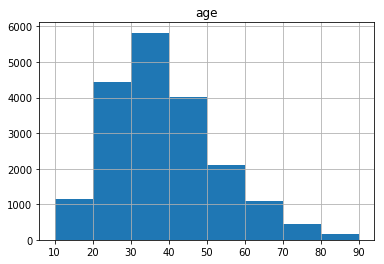

In [53]:
sample_df.hist(column=['age'], bins=8)

### Distribution of Gender

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4f5002e400>]], dtype=object)

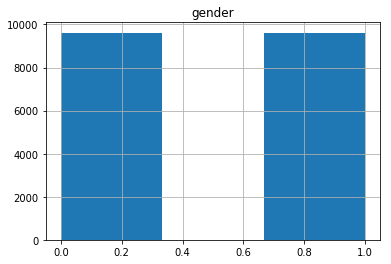

In [54]:
sample_df.hist(column=['gender'], bins=3)

## Add Parent Paths and Image paths to the Dataframe

In [55]:
DATA_PATH = Path("/home/jupyter/imdb-face-data")
DATASET_PATH = DATA_PATH / "imdb_crop"

In [56]:
sample_df.head()

,dob,photo_taken,full_path,gender,name,age,size_W_H,mode
0,1984,2011,/home/jupyter/imdb-face-data/imdb_crop/40/nm22...,0.0,Taylor Schilling,27,"(500, 500)",RGB
1,1950,1983,/home/jupyter/imdb-face-data/imdb_crop/54/nm05...,0.0,Ofelia Medina,33,"(500, 500)",RGB
2,1948,2013,/home/jupyter/imdb-face-data/imdb_crop/47/nm00...,0.0,Barbara Hershey,65,"(500, 500)",RGB
3,1982,2013,/home/jupyter/imdb-face-data/imdb_crop/96/nm23...,0.0,Fala Chen,31,"(500, 500)",RGB
4,1970,2013,/home/jupyter/imdb-face-data/imdb_crop/96/nm11...,0.0,Alysia Reiner,43,"(500, 500)",RGB


In [57]:
sample_df['full_path'] = sample_df['full_path'].apply(lambda x: Path(x))
sample_df.rename(columns={'full_path' : 'absolute_path'}, inplace=True)
sample_df['parent_path'] = sample_df['absolute_path'].apply(lambda x: x.relative_to(DATASET_PATH))
sample_df['img_path'] = sample_df['absolute_path'].apply(lambda x: x.relative_to(x.parent))

In [58]:
sample_df.head()

,dob,photo_taken,absolute_path,gender,name,age,size_W_H,mode,parent_path,img_path
0,1984,2011,/home/jupyter/imdb-face-data/imdb_crop/40/nm22...,0.0,Taylor Schilling,27,"(500, 500)",RGB,40/nm2279940_rm2559819520_1984-7-27_2011.jpg,nm2279940_rm2559819520_1984-7-27_2011.jpg
1,1950,1983,/home/jupyter/imdb-face-data/imdb_crop/54/nm05...,0.0,Ofelia Medina,33,"(500, 500)",RGB,54/nm0575754_rm2285080064_1950-3-4_1983.jpg,nm0575754_rm2285080064_1950-3-4_1983.jpg
2,1948,2013,/home/jupyter/imdb-face-data/imdb_crop/47/nm00...,0.0,Barbara Hershey,65,"(500, 500)",RGB,47/nm0001347_rm2334775552_1948-2-5_2013.jpg,nm0001347_rm2334775552_1948-2-5_2013.jpg
3,1982,2013,/home/jupyter/imdb-face-data/imdb_crop/96/nm23...,0.0,Fala Chen,31,"(500, 500)",RGB,96/nm2371196_rm1343148800_1982-2-24_2013.jpg,nm2371196_rm1343148800_1982-2-24_2013.jpg
4,1970,2013,/home/jupyter/imdb-face-data/imdb_crop/96/nm11...,0.0,Alysia Reiner,43,"(500, 500)",RGB,96/nm1130496_rm3249586944_1970-7-21_2013.jpg,nm1130496_rm3249586944_1970-7-21_2013.jpg


#### Save the Sample CSV File with those new infos

In [59]:
sample_df.to_csv('/home/jupyter/imdb-face-data/imdb_crop/imdb-sample-metafull.csv',index=False, encoding='utf-8')

### CREATE A SAMPLE DATA FOLDER (copy images from our sample csv)

In [60]:
SAMPLE_DATA_PATH = '/home/jupyter/imdb-face-data/imdb_crop/imdb-sample/imdb-sample-data'

In [61]:
import shutil
import os.path

def create_sample_data_folder(source, dest):
    os.mkdir(dest)
    for path in source:
        try:
            shutil.copy2(str(path), dest)
        except:
            print(path)

In [62]:
create_sample_data_folder(sample_df['absolute_path'], SAMPLE_DATA_PATH)

### Verify Images in our Sample

In [63]:
verify_images(SAMPLE_DATA_PATH)